In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Arial']
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score

In [ ]:
dataset = pd.read_csv('/Users/csuen/radicals/UKESM1-0-LL_2010_2014.csv')

In [ ]:
land = pd.read_csv('/Users/csuen/Documents/GitHub/ozone-budget/global_grid_2x2_label_continent.csv')
dataset_land = dataset.merge(land, how='left', left_on=['longitude','latitude'], right_on=['longitude','latitude'])
dataset_land = dataset_land[dataset_land['land_global']==1] 

In [ ]:
dataset_land['o3net_mole'] = dataset_land['o3prod_mole'] - dataset_land['o3loss_mole'] 

In [ ]:
dataset_land_grid = dataset_land.groupby('loc_x').mean()[['eminox','emivoc']]
dataset_land_grid.to_csv('emission grid-average.csv')
emis_ave = pd.read_csv('emission grid-average.csv')
emis_ave = emis_ave.rename(columns={"eminox": "eminox_ave", "emivoc": "emivoc_ave"}) 

In [ ]:
dataset_land = dataset_land.merge(emis_ave, how='left', left_on=['loc_x'], right_on=['loc_x'])
dataset_land 

,longitude,latitude,t,loc_x,o3,o3prod,o3loss,eminox,emivoc,tas,...,loc_y,seq,circle,placename,land_earth,land_global,CONTINENT,o3net_mole,eminox_ave,emivoc_ave
0,69.0,-49.0,1.0,68951.0,1.471148e-08,3.211922e-13,2.722755e-13,6.111121e-13,8.230395e-12,279.33667,...,11180,3081,69,French Southern & Antarctic Lands,1,1,Antarctica,2.945764e+04,6.125379e-13,4.646854e-12
1,169.0,-45.0,1.0,168955.0,1.456359e-08,2.490233e-12,6.123487e-13,6.684854e-12,1.961126e-10,286.22003,...,15682,7583,169,New Zealand,1,1,Oceania,1.130862e+06,6.565225e-12,8.799238e-11
2,171.0,-45.0,1.0,170955.0,1.623399e-08,4.713648e-12,7.773185e-13,5.938116e-12,1.148444e-10,286.87515,...,15772,7673,171,New Zealand,1,1,Oceania,2.370458e+06,6.050911e-12,5.023277e-11
3,147.0,-43.0,1.0,146957.0,1.990147e-08,4.032379e-12,1.018624e-12,6.746558e-12,1.089857e-10,288.73615,...,14693,6594,147,Australia,1,1,Australia,1.814883e+06,7.110824e-12,5.226175e-11
4,171.0,-43.0,1.0,170957.0,1.529586e-08,2.395443e-12,7.764943e-13,5.167356e-12,2.154613e-10,288.01100,...,15773,7674,171,New Zealand,1,1,Oceania,9.749310e+05,5.398532e-12,9.574584e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232315,-35.0,83.0,60.0,325083.0,1.944581e-08,1.879754e-16,3.207016e-16,8.447100e-14,4.913423e-16,235.54500,...,6566,14667,325,Greenland,1,1,North America,-7.992770e+01,8.372332e-14,5.026281e-16
232316,-31.0,83.0,60.0,329083.0,1.909269e-08,2.111646e-16,2.945706e-16,9.493963e-14,9.205029e-16,235.85202,...,6746,14847,329,Greenland,1,1,North America,-5.022706e+01,9.517656e-14,9.416517e-16
232317,-29.0,83.0,60.0,331083.0,1.874725e-08,2.106560e-16,1.801800e-16,1.413331e-13,1.779273e-15,235.96560,...,6836,14937,331,Greenland,1,1,North America,1.835267e+01,1.409455e-13,1.816621e-15
232318,-27.0,83.0,60.0,333083.0,1.836742e-08,2.978477e-17,1.012632e-16,4.734165e-14,3.160282e-17,235.80554,...,6926,15027,333,Greenland,1,1,North America,-4.304430e+01,4.550616e-14,3.231475e-17


In [ ]:
dataset_land['eminox_p'] = dataset_land['eminox']/dataset_land['eminox_ave']
dataset_land['emivoc_p'] = dataset_land['emivoc']/dataset_land['emivoc_ave']

dataset_land['N'] = dataset_land['eminox_p']
dataset_land['N2'] = dataset_land['eminox_p']**2
dataset_land['NV'] = dataset_land['eminox_p']*dataset_land['emivoc_p']
dataset_land['V'] = dataset_land['emivoc_p']
dataset_land['V2'] = dataset_land['emivoc_p']**2 

In [ ]:
dataset_land = dataset_land.dropna() 

In [ ]:
coef = dataset_land.groupby('loc_x').apply(lambda g: sm.OLS(endog=g['o3net_mole']*10**(-6), exog=g[['eminox_p','emivoc_p']]).fit().params)

coord['Sn'] = coef['eminox_p']
coord['Sv'] = coef['emivoc_p']
coord['SnSv'] = coord['Sn']/coord['Sv'] 

In [ ]:
coef 

,eminox_p,emivoc_p
loc_x,,
1007.0,4.643417,1.491373
1009.0,4.758675,1.633897
1011.0,1.966960,2.992600
1013.0,0.461337,3.831023
1015.0,1.305974,2.407488
...,...,...
359045.0,0.006752,2.943472
359047.0,-0.824551,3.630210
359049.0,-1.167805,3.579772


In [ ]:
plt.figure(num=None, figsize=(20, 2.75), dpi=100, facecolor='w', edgecolor='k')
cm = plt.cm.get_cmap('RdYlBu')
x = coord['longitude']
y = coord['latitude']

plt.subplot(1,3,1)
plt.title('Sn', fontsize = 20, fontname = "Arial", color = "black")
z = coord['Sn']
sc = plt.scatter(x, y, c=z, marker="s", vmin=-5, vmax=5, s=2, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-60, 75])
plt.colorbar(fraction=0.02)

In [ ]:
plt.figure(num=None, figsize=(20, 2.75), dpi=100, facecolor='w', edgecolor='k')
cm = plt.cm.get_cmap('RdYlBu')
x = coord['longitude']
y = coord['latitude']

plt.subplot(1,3,1)
plt.title('SnSv', fontsize = 20, fontname = "Arial", color = "black")
z = coord['SnSv']
sc = plt.scatter(x, y, c=z, marker="s", vmin=-1, vmax=2, s=2, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-60, 75])
plt.colorbar(fraction=0.02)

(-60.0, 75.0)

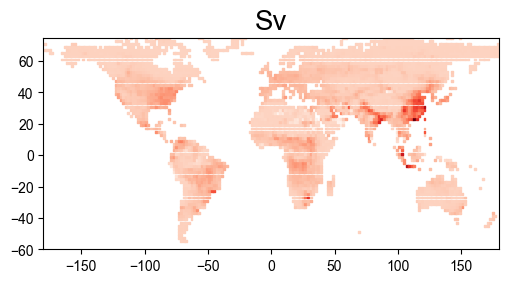

In [ ]:
temp = coord

plt.figure(num=None, figsize=(20, 2.75), dpi=100, facecolor='w', edgecolor='k')
cm = plt.cm.get_cmap('Reds')
x = temp['longitude']
y = temp['latitude']

plt.subplot(1,3,1)
plt.title('Sv', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['Sv'])
sc = plt.scatter(x, y, c=z, marker="s",s=2, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-60, 75])
#plt.colorbar(fraction=0.02) 

In [ ]:
coord 

,longitude,latitude,Sn,Sv,SnSv,FNR,HOP,LER_etoo,LER_isop,Sv_adj,Sn_adj,SnSv_adj
loc_x,,,,,,,,,,,,
1007.0,1.0,7.0,4.643417e+06,1.491373e+06,3.113518,0.847337,0.588327,0.001990,0.136939,1.491373,10.503281,7.042691
1009.0,1.0,9.0,4.758675e+06,1.633897e+06,2.912470,1.031314,0.455310,0.004121,0.576027,1.633897,10.733796,6.569445
1011.0,1.0,11.0,1.966960e+06,2.992600e+06,0.657275,0.971161,0.600245,0.002400,0.199374,2.992600,5.150366,1.721034
1013.0,1.0,13.0,4.613372e+05,3.831023e+06,0.120421,0.857094,0.708265,0.000656,0.020673,3.831023,2.139121,0.558368
1015.0,1.0,15.0,1.305974e+06,2.407488e+06,0.542463,0.890078,0.762063,0.000474,0.010954,2.407488,3.828394,1.590203
...,...,...,...,...,...,...,...,...,...,...,...,...
359045.0,-1.0,45.0,6.752232e+03,2.943472e+06,0.002294,0.344742,0.354096,0.000573,0.156564,2.943472,1.229951,0.417857
359047.0,-1.0,47.0,-8.245514e+05,3.630210e+06,-0.227136,0.170657,0.225052,0.000050,0.012392,3.630210,-0.432657,-0.119182
359049.0,-1.0,49.0,-1.167805e+06,3.579772e+06,-0.326223,0.118948,0.155709,0.000025,0.008964,3.579772,-1.119163,-0.312635


In [ ]:
coord['FNR_NO2'] = FNR_NO2_map['FNR_NO2']
coord['FNR_NOy'] = fnr_noy_map['FNR_NOy']
coord['FNR_NOx'] = FNR_NOx_map['FNR_NOx'] 

In [ ]:
coord.to_csv('regime diagnosis map.csv', index=False) 